In [559]:
from utils import create_df, compute_fingerprints, compute_descriptors, create_data, eval_metrics

In [560]:
import numpy as np
import pandas as pd
import numpy as np
import rdkit
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator

from sklearn.model_selection import train_test_split

In [561]:
# Bloack for auto loading of imports from outside scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Предсказание фазы:

In [562]:
descriptors = [
    "NumHBD",                # Number of Hydrogen Bond Donors (rdMolDescriptors)
    "NumHeavyAtoms",         # Number of Heavy Atoms

    'MolWt',                 # Molecular Weight
    'LogP',                  # LogP (octanol-water partition coefficient)
    'TPSA',                  # Topological Polar Surface Area
    'NumRotatableBonds',     # Number of Rotatable Bonds
    'NumHDonors',            # Number of Hydrogen Bond Donors
    'NumHAcceptors',         # Number of Hydrogen Bond Acceptors
    'FractionCSP3',          # Fraction of sp3 Hybridized Carbons
    'NumAromaticRings',      # Number of Aromatic Rings
    'FractionRotatableBonds',# Fraction of Rotatable Bonds
    'NumHBD',               
    'NumHBA',                # Number of Hydrogen Bond Acceptors (rdMolDescriptors)
    'NumRings',              # Number of Rings
    'NumHeteroatoms',        # Number of Heteroatoms
    'Chi0v',                 # Chi Connectivity Index 0 (Valence)
    'Chi1v',                 # Chi Connectivity Index 1 (Valence)
    'Chi2v',                 # Chi Connectivity Index 2 (Valence)
]

data_path = "./data/medium_dataset_solid_liquid_with_T_melt_data"
columns = ['line_number', 'smiles', 'cas', 'label', 'T']

df = create_df(data_path, columns)
df['T'] = df['T'].replace('fail', np.nan).astype(float)

### Трейн для классификации - все у чего нет температуры, остальное - тест, чтобы можно было идею с расстоянием до плоскости использовать:

- Получается Morgan Fingerprints почти что бесполезные - случайный фактор будет лучше или нет

In [563]:
data_args = {
    "descriptors": descriptors,
    "apply_norm": False,
    "create_fingerprints": False
}

In [564]:
df_no_temp = df[df["T"].isna()]
df_temp = df[df["T"].notna()]
temp = df_temp["T"]

_, X_no_temp, labels_train = create_data(df_no_temp, **data_args)
_, X_temp, labels_test = create_data(df_temp, **data_args)

#### Catboost:

In [565]:
from catboost import CatBoostClassifier, CatBoostRegressor

##### Phase Classification:

In [566]:
model_args = {
    "iterations": 1000,
    "learning_rate": 0.01,
    "depth": 11,
    # "loss_function": 'Logloss',
    "verbose": 0,
    "random_seed": 100,
    "l2_leaf_reg": 0.01
}

classifier = CatBoostClassifier(**model_args)
classifier.fit(X_no_temp, labels_train, eval_set=(X_temp, labels_test))

y_pred_at = classifier.predict(X_temp)

In [567]:
eval_metrics(labels_test, y_pred_at)

{'ACC': 0.8942857142857142,
 'BAL-ACC': 0.9065405137796358,
 'ROC-AUC': 0.9065405137796357,
 'R2': 0.45724920696041216}

#### Catboost Feature Importance:

In [568]:
phase_pred_importance = classifier.get_feature_importance()

phase_pred_importance = phase_pred_importance / phase_pred_importance.sum()

Text(0, 0.5, 'Feature Importance')

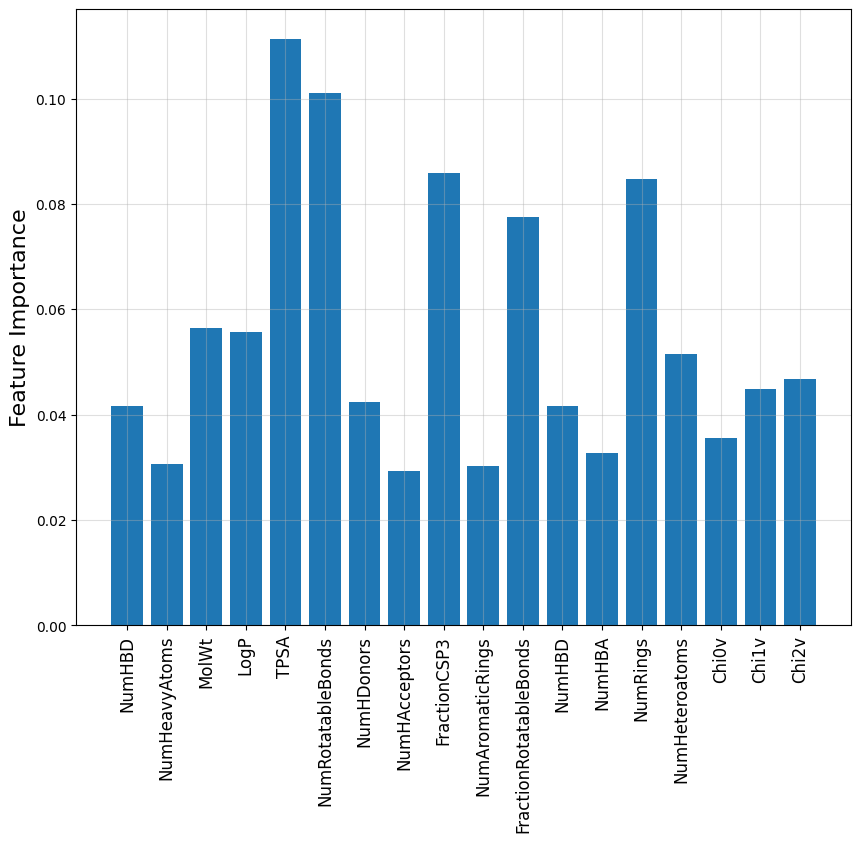

In [569]:
plt.figure(figsize=(10, 8))

plt.bar(range(len(phase_pred_importance)), phase_pred_importance, tick_label=descriptors)

plt.grid(alpha=0.4)
plt.xticks(rotation=90, fontsize=12)  # Rotate labels by 45 degrees
plt.ylabel("Feature Importance", fontsize=16)


---
## Temperature Regression:

### Only Molecular features:

In [570]:
model_args = {
    "iterations": 1000,
    "learning_rate": 0.1,
    "depth": 7,
    # "loss_function": 'Logloss',
    "verbose": 0,
    "random_seed": 100,
    "l2_leaf_reg": 1
}
TEST_SIZE = 0.4


temp_regressor = CatBoostRegressor(**model_args)

X_temp_train, X_temp_val, temp_train, temp_val = train_test_split(X_temp, temp, test_size=TEST_SIZE)

temp_regressor.fit(X_temp_train, temp_train, eval_set=(X_temp_val, temp_val))

temp_pred = temp_regressor.predict(X_temp_val)

In [571]:
eval_metrics(temp_pred, temp_val, type="regression")

{'MSE': 3702.888313908632,
 'RMSE': 60.85136246550797,
 'MAE': 44.01912793343159,
 'R2': 0.49732142789434697}

/var/folders/1r/q2t9qwhn5p52b7p0bhtkg3pc0000gq/T/ipykernel_51982/3454918047.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=16)


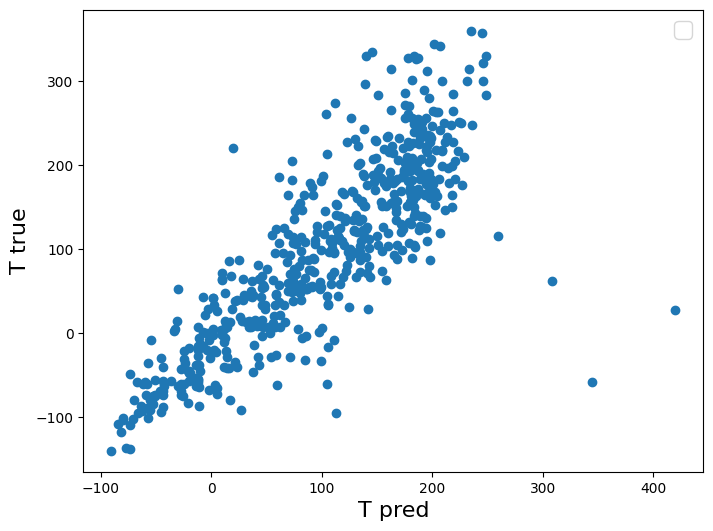

In [572]:
plt.figure(figsize=(8, 6))

plt.scatter(
    temp_pred, temp_val
)

plt.xlabel("T pred", fontsize=16)
plt.ylabel("T true", fontsize=16)

plt.legend(fontsize=16)

In [573]:
temp_regr_importance = temp_regressor.get_feature_importance()

temp_regr_importance = temp_regr_importance / temp_regr_importance.sum()

Text(0, 0.5, 'Feature Importance')

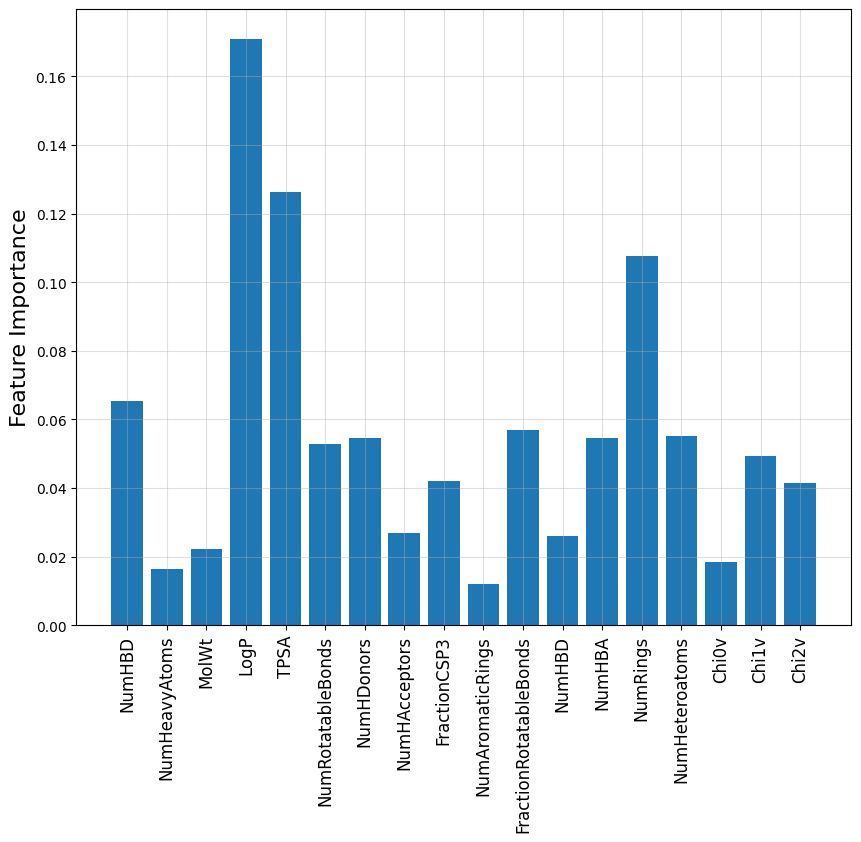

In [574]:
plt.figure(figsize=(10, 8))

plt.bar(range(len(temp_regr_importance)), temp_regr_importance, tick_label=descriptors)

plt.grid(alpha=0.4)
plt.xticks(rotation=90, fontsize=12)  # Rotate labels by 45 degrees
plt.ylabel("Feature Importance", fontsize=16)


---
### Только на жидкостях

In [635]:
df_temp_liquids = df_temp[df_temp["T"] < 50]
# df_temp_solids = df_temp[df_temp["T"] >= 50]

T_liquids = df_temp_liquids["T"]
# T_solids = df_temp_solids["T"]

In [636]:
_, X_liquids, _ = create_data(df_temp_liquids, **data_args)
# _, X_solids, _ = create_data(df_temp_solids, **data_args)

In [637]:
temp_regressor_liq_trained = CatBoostRegressor(**model_args)

X_liq_train, X_liq_val, temp_liq_train, temp_liq_val = train_test_split(X_liquids, T_liquids, test_size=0.5)

temp_regressor_liq_trained.fit(X_liq_train, temp_liq_train, eval_set=(X_liq_val, temp_liq_val))

temp_pred = temp_regressor_liq_trained.predict(X_liq_val)

In [638]:
eval_metrics(temp_pred, temp_liq_val, type="regression")

{'MSE': 952.0831327260584,
 'RMSE': 30.855844385238566,
 'MAE': 24.289204004049687,
 'R2': 0.2503273278890784}

/var/folders/1r/q2t9qwhn5p52b7p0bhtkg3pc0000gq/T/ipykernel_51982/400687121.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=16)


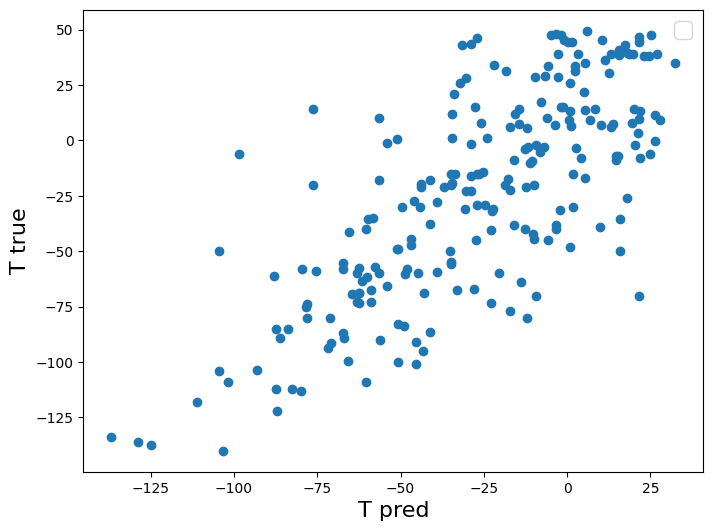

In [639]:
plt.figure(figsize=(8, 6))

plt.scatter(
    temp_pred, temp_liq_val
)

plt.xlabel("T pred", fontsize=16)
plt.ylabel("T true", fontsize=16)

plt.legend(fontsize=16)

In [640]:
liq_mol_importance = temp_regressor_liq_trained.get_feature_importance()

liq_mol_importance = liq_mol_importance / liq_mol_importance.sum()

Text(0, 0.5, 'Feature Importance')

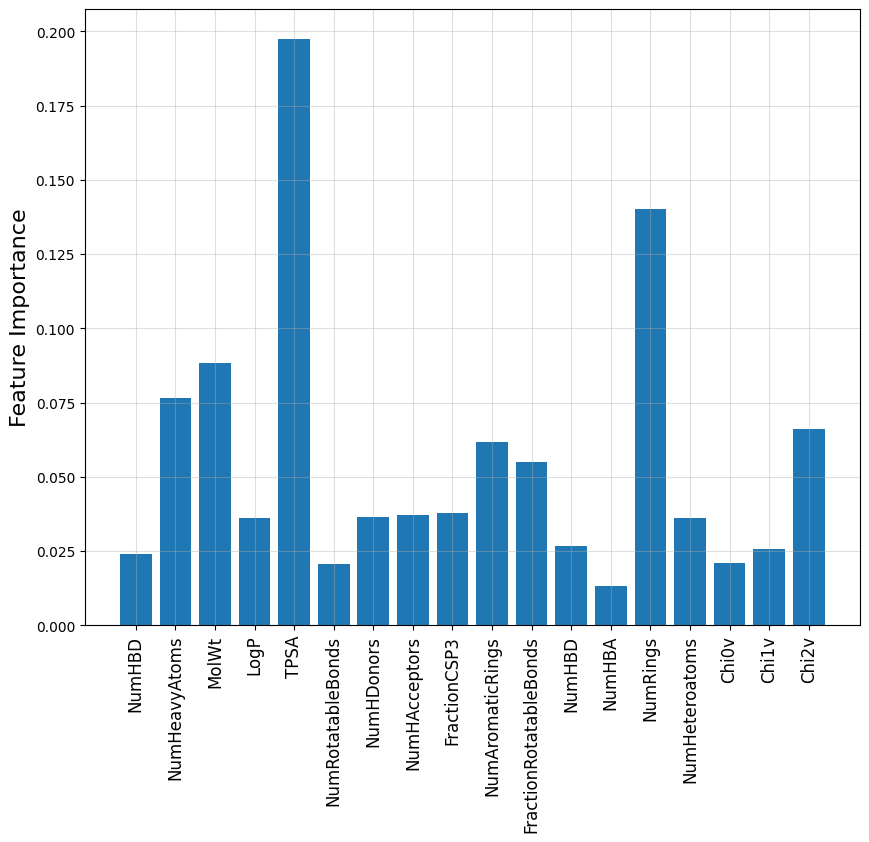

In [641]:
plt.figure(figsize=(10, 8))

plt.bar(range(len(liq_mol_importance)), liq_mol_importance, tick_label=descriptors)

plt.grid(alpha=0.4)
plt.xticks(rotation=90, fontsize=12)  # Rotate labels by 45 degrees
plt.ylabel("Feature Importance", fontsize=16)


#### Обученное расстояние до плоскости на всех фичах и твердых телах в том числе используем для предсказания Т плавления жидкостей:

In [642]:
dist_liq_train = classifier.predict_proba(X_liq_train)[:, 0].reshape(-1, 1)
dist_liq_val = classifier.predict_proba(X_liq_val)[:, 0].reshape(-1, 1)

In [643]:
temp_regr_dist = CatBoostRegressor(**model_args)

temp_regr_dist.fit(dist_liq_train, temp_liq_train, eval_set=(dist_liq_val, temp_liq_val))

temp_pred = temp_regr_dist.predict(dist_liq_val)

In [644]:
eval_metrics(temp_pred, temp_liq_val, type="regression")

{'MSE': 1066.0440940431265,
 'RMSE': 32.650330688112895,
 'MAE': 26.21015710095823,
 'R2': 0.05681237172255216}

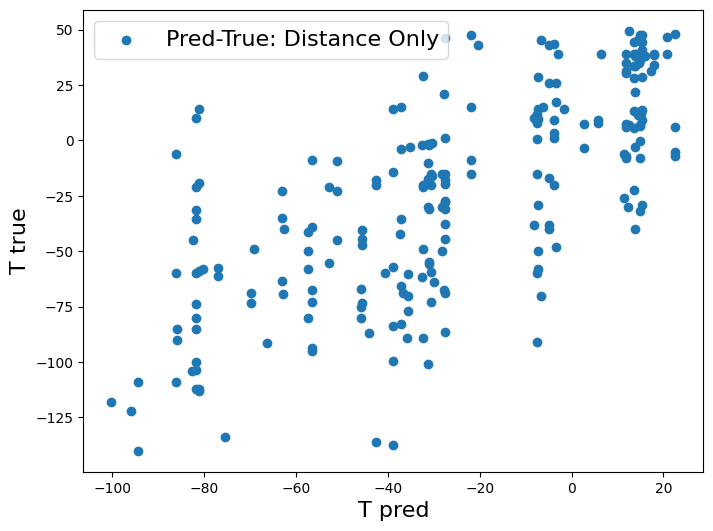

In [645]:
plt.figure(figsize=(8, 6))

plt.scatter(
    temp_pred, temp_liq_val, label="Pred-True: Distance Only"
)

plt.xlabel("T pred", fontsize=16)
plt.ylabel("T true", fontsize=16)

plt.legend(fontsize=16)

#### Расстояние + TPSA + NumRings для жидкост:

In [658]:
data_args_limited = {
    "descriptors": ["TPSA", "NumRings", "Chi2v"],
    "apply_norm": False,
    "create_fingerprints": False
}

_, X_liquids_limited, _ = create_data(df_temp_liquids, **data_args_limited)
dist_liqs = classifier.predict_proba(X_liquids)[:, 0].reshape(-1, 1)

X_liquids_limited = np.concatenate([X_liquids_limited,  dist_liqs], axis=1)

In [659]:
temp_regressor_liq_trained = CatBoostRegressor(**model_args)

X_liq_train, X_liq_val, temp_liq_train, temp_liq_val = train_test_split(X_liquids_limited, T_liquids, test_size=0.5)

temp_regressor_liq_trained.fit(X_liq_train, temp_liq_train, eval_set=(X_liq_val, temp_liq_val))

temp_pred = temp_regressor_liq_trained.predict(X_liq_val)

In [660]:
eval_metrics(temp_pred, temp_liq_val, type="regression")

{'MSE': 1031.749159622225,
 'RMSE': 32.12085241120206,
 'MAE': 25.973103481996528,
 'R2': 0.2076840446587609}

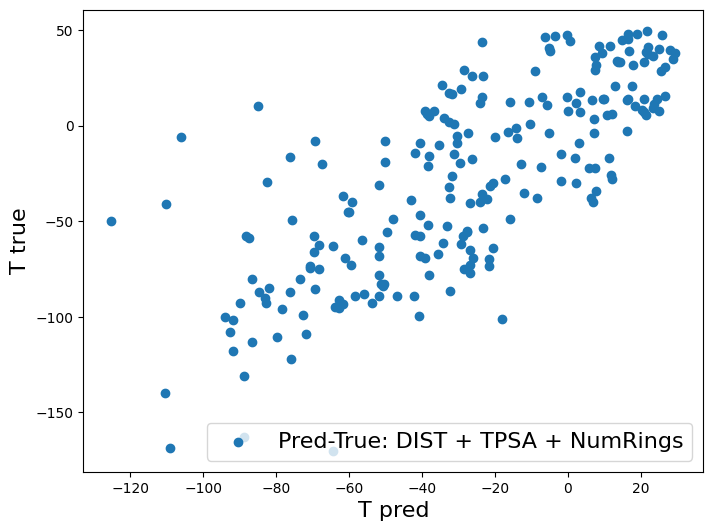

In [661]:
plt.figure(figsize=(8, 6))

plt.scatter(
    temp_pred, temp_liq_val, label="Pred-True: DIST + TPSA + NumRings"
)

plt.xlabel("T pred", fontsize=16)
plt.ylabel("T true", fontsize=16)

plt.legend(fontsize=16)

---
### Корреляция LogP дескриптора:

In [662]:
df_descriptors = pd.DataFrame(X_no_temp, columns=descriptors)

In [663]:
df_descriptors.corr()["LogP"].sort_values()

NumHBD                   -0.394390
NumHBD                   -0.394390
NumHDonors               -0.394390
TPSA                     -0.344948
NumHBA                   -0.256765
NumHAcceptors            -0.256765
NumHeteroatoms           -0.229290
FractionRotatableBonds    0.015305
FractionCSP3              0.015305
NumRings                  0.082189
NumAromaticRings          0.194613
NumHeavyAtoms             0.314828
MolWt                     0.315105
Chi2v                     0.394169
Chi0v                     0.412488
Chi1v                     0.436808
NumRotatableBonds         0.498151
LogP                      1.000000
Name: LogP, dtype: float64